> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

<h4><div style="text-align: right"> Due date: April 1, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab04.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [ ]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-03-25 07:16:08.635253


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [ ]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [ ]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [ ]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


![image.png](attachment:image.png)

In [ ]:
print('STEP 1: DEFINE DATASET')

## 질문 1. mnist data set이 1channel인지 -> 맞다.
# 질문 2. normalize의 이유 -> 학습이 더 빠르다., 분포를 맞춰준다.
## 질문 4. translate 역할 -> Placing the digit in a random location in a  40×40  region of image's center
##-> 첨언을 하자면 28 x 28 을 40x40까지 움직일 수 있으면 40/28은 이쁜 수가 아난데?
## 질문 5. compose는 구성 순서대로 돌아가나? 그렇다면 zero padding 후에 randomlocation을 돌리는 것이 맞는 것이 아닌가?(질문 4와 연관됨)
## 질문 5 답 -> padding을 먼저해라.
# 질문 6 transform을 하면 mean값과 분산 값이 변하지 않는가? -> 변하지만 문제는 삼지 않는다.

transform_train = transforms.Compose([
    transforms.Pad(26, fill=0, padding_mode='constant'),
    transforms.RandomAffine((-45,45),scale=(0.7,1.2),translate=(0.25,0.25)),
    # 첫번째 tuple이 rotation을 의미하고 scale 부분은 random scaling을 담당한다.
    # translate는 shift를 의미하는 것으로 위의 그림을 보면 알 수 있듯이 -20<dx<20 주변으로 움직여야 하므로 0.25로 a.b를 설정해야 한다.
    # 그림이 짤리는 관계로 말로 설명하자면 지금 우리한테 있는 것은 80,80 짜리 그림이다. 여기서 중심은 (40,40) 이다. [ python indexing이 아니다.]
    # 그렇기 때문에 중심에서 40,40이면 대칭적인 구조이므로 20만큼 차이가 나게 설계되어 있다. 그래서 -20<dx<20이다. 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 본래는 train만 transform(변형 시키는)을 해주지만 이 실험은 변형된 것도 잘 classfication하는지 보는 것이므로 test도 해주어야 한다. 
transform_test = transforms.Compose([
    transforms.Pad(26, fill=0, padding_mode='constant'),
    transforms.RandomAffine((-45,45),scale=(0.7,1.2),translate=(0.25,0.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

## 질문 3. target_transform의 의미? ->  label의 형식을 바꾸는 transform입니다. 예를 들어 label을 onehot vector (matrix) 으로 바꾸는 용도로 사용할 수 있습니다.
train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        transform=transform_train,
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        transform=transform_test,
                        target_transform=None,
                        download=False)

train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [ ]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


In [ ]:
train_dataset[0][0].size()

torch.Size([1, 80, 80])

###  Visualize Dataset


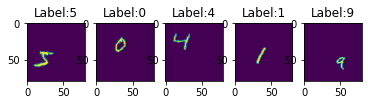

In [ ]:
figure = plt.figure()

# 의미 있는 결과를 볼 수 있다. 
for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,5,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 4:
        plt.show()
        break

In [ ]:
print('STEP 2: LOADING DATASET')
# batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [ ]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')

# tunctional.grid_sample -> sampling

# Conv -> Conv -> FC -> RC

# input img    (1,80,80)
# STN 1st conv (20,76,76) 질문 -> 오픈 소스를 봤는데 STN 다음에서도 conv 다음에서도 maxpooling를 사용하는데? 
# maxpooling    (20,38,38)
# STN 2nd conv (20,34,34) 질문 -> 절대 23120이 나올수 없는데? -> 맨 마지막 maxmpooling을 제거하라 
# maxpooling    (20,17,17)
# STN output (batch size,23120=20x34x34)
# STN fc_loc output (batchsize, 20) -> (batchsize, 6) -> (batchsize, 2,3)
# CNN input (32)

## 아래 시나리오는 걍 틀림.
# 다음 시나리오
# input img (1,80,80)
# avg pooling (1,40,40)
# STN 1st  conv (20,36,36)
# STN 2nd  conv (20,32,32)


# input img (1,80,80)
# STN 1st  conv (20,76,76)
# STN 2nd  conv (20,72,72)
# avg pooling (20,36,36)

class STN_CNN(nn.Module):
    def __init__(self) :
        super(STN_CNN, self).__init__()
        self.cnn = nn.Sequential(
            # (1,40,40)
            nn.Conv2d(1, 32, kernel_size=9),nn.MaxPool2d(kernel_size=2, stride=2),nn.ReLU(),
            # (32,32,32) -> (32,16,16)
            nn.Conv2d(32, 64, kernel_size=7),nn.MaxPool2d(kernel_size=2, stride=2),nn.ReLU()
            # (64,10,10) -> (64,5,5)
        )
        
        self.classifier = nn.Sequential(
            # 1600 = 64 * 5 * 5
            nn.Linear(1600, 128),nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            #(1,80,80)
            nn.Conv2d(1, 20, kernel_size=5),
            #(20,76,76)
            nn.MaxPool2d(2, stride=2),nn.ReLU(True),
            #(20,38,38)
            nn.Conv2d(20, 20, kernel_size=5),nn.ReLU(True)
            #(20,34,34)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(20 * 34 * 34, 20),nn.ReLU(), # 23120 = 20 x34 x34
            nn.Linear(20, 6)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])
        
        self.avgpool = nn.AvgPool2d(2, stride=2)

    # Spatial transformer network forward function
    def stn(self, x):
        # input feature map : (1, 80, 80)
        xs = self.localization(x)
        # localization은 2개의 conv layer를 통과한다.
        # output feature map : (20, 34, 34)
        # 20, 34, 34, 이 linear 연산을 할 수 있는 1-D로 변환한다.
        xs = xs.view(-1, 20 * 34 * 34)
        # theta는 affine 변환을 위한 parameter이다.
        theta = self.fc_loc(xs)
        # theta = (batch,6)
        theta = theta.view(-1, 2, 3)
        # theta = (batch_size, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        # x : input (1, 80, 80)
        x = self.stn(x)
        # stn 통해 나온 output은 str의 원래 input과 동일한 size이다.
        # 즉 그냥 공간적 변형에 대해 전처리된 이미지라고 생각하면 된다.
        x = self.avgpool(x)
        # 변형된 input (1,40,40)
        # 여기서부터는 일반적인 classification을 위한 forward pass 와 동일하다.
        x = self.cnn(x)
        x = x.view(-1, 1600)        
        x = self.classifier(x)
        return x

STEP 3: CREATE MODEL CLASS (STN_CNN)


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS')

num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(model.to(device))
print(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  782344
STN_CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (localization): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=23120, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(

In [ ]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [ ]:
print('STEP 6: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()
# Model to GPU
model.to(device)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        images = img.to(device)
        labels = label.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        if j % 200 == 0:
            #0번째와 200x256(batch size)에서만 출력하겠다. 
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))

    #Test
    model.eval()
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    # Print Loss
    print('Epochs: {}. Loss: {:.2f}. Accuracy: {:.2f}. Elapsed time: {:.2f}sec'.format(epoch, loss.item(), accuracy, time.time() - start))
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy) # 이부부은 이건 반드시 이 위치에 있어야 의미가 있다. 그 이유는 정확도 계산이 다 끝이 나고 그 정확도가 일정 기간 유지가 되면 learning rate를 줄인다는 사명을 가지고 있기 때문이다.


STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.306952  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.642625  
Epochs: 0. Loss: 0.62. Accuracy: 83.02. Elapsed time: 7.83sec
Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.478071  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.318883  
Epochs: 1. Loss: 0.28. Accuracy: 91.70. Elapsed time: 7.86sec
Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.206449  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.182416  
Epochs: 2. Loss: 0.21. Accuracy: 94.68. Elapsed time: 7.61sec
Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.184111  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.189655  
Epochs: 3. Loss: 0.07. Accuracy: 96.31. Elapsed time: 7.64sec
Train Epoch: 4 [0/60000 (0%) / Learning rate:0.001]	Loss:0.106542  
Train Epoch: 4 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.0

Epochs: 39. Loss: 0.01. Accuracy: 98.92. Elapsed time: 7.40sec
Train Epoch: 40 [0/60000 (0%) / Learning rate:0.0001]	Loss:0.032271  
Train Epoch: 40 [51200/60000 (85%) / Learning rate:0.0001]	Loss:0.037738  
Epochs: 40. Loss: 0.05. Accuracy: 98.95. Elapsed time: 7.51sec
Train Epoch: 41 [0/60000 (0%) / Learning rate:0.0001]	Loss:0.038431  
Train Epoch: 41 [51200/60000 (85%) / Learning rate:0.0001]	Loss:0.021896  
Epochs: 41. Loss: 0.03. Accuracy: 99.16. Elapsed time: 7.47sec
Train Epoch: 42 [0/60000 (0%) / Learning rate:0.0001]	Loss:0.039885  
Train Epoch: 42 [51200/60000 (85%) / Learning rate:0.0001]	Loss:0.018270  
Epochs: 42. Loss: 0.02. Accuracy: 98.97. Elapsed time: 7.63sec
Train Epoch: 43 [0/60000 (0%) / Learning rate:0.0001]	Loss:0.059482  
Train Epoch: 43 [51200/60000 (85%) / Learning rate:0.0001]	Loss:0.028353  
Epochs: 43. Loss: 0.05. Accuracy: 99.13. Elapsed time: 7.72sec
Train Epoch: 44 [0/60000 (0%) / Learning rate:0.0001]	Loss:0.034151  
Train Epoch: 44 [51200/60000 (85%) 

실험 결과를 보면 알 수 있다시피 99%에 달하는 정확도로 변형된 mnist set을 잘 classification하는 것을 확인할 수 있다. 

개선할 점 : 변형된 mnist set에 대해서는 정확도가 99%이니 개선할 점이라고는 딱히 없지만 단점이 적은 양이지만 ST module로 인해 parameter이 증가한다는 것이다. 이를 해결할 수 있는 전처리 모델이면 더 속도가 빨라질 것이고 실시간 분류작업에도 문제 없이 쓰일 수 있을 것이다. 실제로 논문에서는 ST를 삽입한 것으로 약 6% 실행시간이 늘어난다고 서술하고 있다. 

일치하는 점 : 변형된 data set에도 정확도가 높다는 것이 논문과 일치한다. 이 결과는 아래 ST module 없이 돌릴때와 비교하면 어떤 효과가 있는지 바로 알수 있다. 

차이가 나는 점 : 이건 논문과의 차이보다는 torch에서 제공하는 ST module과 차이가 난다. 큰 차이는 아니고 kernel size라던지 maxpooling이 한개 차이가 난다던지 구조적인 차이가 있다.

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [ ]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [ ]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  99.15865384615384


In [ ]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re

#made _grid 사용

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [ ]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        self.input_tensor = x.cpu()
        self.transformed_input_tensor = model.stn(x).cpu()
    
    def visualize(self, img):
        self.forward_stn(img)
        in_grid = reprocess_image(
            v_utils.make_grid(self.input_tensor, nrow = 4)
        )

        out_grid = reprocess_image(
            v_utils.make_grid(self.transformed_input_tensor, nrow = 4)
        )
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        plt.ioff()
        plt.show()

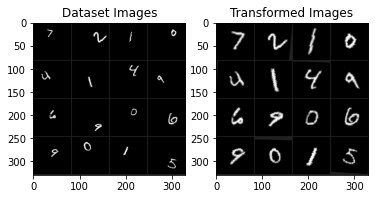

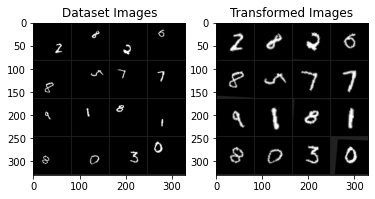

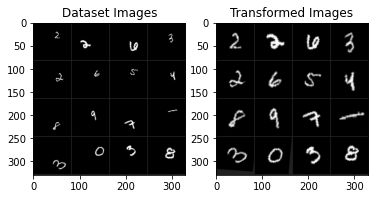

In [ ]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

위의 결과를 보면 변형된 mnist set보다 transformed image(ST module을 통과한 이미지)가 훨씬 정형화되어 있다는 것을 사람이 느끼기에도 느낄 수 있다. attention에 대해서는 명확한 결과이다. 이를 affine 에도 적용할 수 있는데 그럼 회전에 대한 정형화도 높을 수 있다. 현재 데이터는 고작 45도를 플러스 마이너스로 변형해준 것으로 affine 변환에 대해서보다 attention에 집중해서 진행하였다. 

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [ ]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

print('STEP 3: CREATE MODEL CLASS (STN_CNN)')

class CNNWithoutSTN(nn.Module):
    def __init__(self) :
        super(CNNWithoutSTN, self).__init__()
        self.cnn = nn.Sequential(
            # (1,40,40)
            nn.Conv2d(1, 32, kernel_size=9),nn.MaxPool2d(kernel_size=2, stride=2),nn.ReLU(),
            # (32,32,32) -> (32,16,16)
            nn.Conv2d(32, 64, kernel_size=7),nn.MaxPool2d(kernel_size=2, stride=2),nn.ReLU()
            # (64,10,10) -> (64,5,5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),nn.ReLU(),
            nn.Linear(128, 10)
        )
        
        self.avgpool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        # transform the input
        # x : input (1, 80, 80)
        x = self.avgpool(x)
        # 변형된 input (1,40,40)
        # 여기서부터는 일반적인 classification을 위한 forward pass 와 동일
        x = self.cnn(x)
        x = x.view(-1, 1600)        
        x = self.classifier(x)
        return x

# ST moudle만 없고 나머지는 같게 실험만해봐라

STEP 2: LOADING DATASET
STEP 3: CREATE MODEL CLASS (STN_CNN)


In [ ]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model_nostn = CNNWithoutSTN()

print("CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())


STEP 4: INSTANTIATE MODEL CLASS

CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [ ]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


#### 5.2 Train/Test

In [ ]:
print('STEP 6: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()
# Model to GPU
model_nostn.to(device)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        images = img.to(device)
        labels = label.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model_nostn(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        if j % 200 == 0:
            #0번째와 200x256(batch size)에서만 출력하겠다. 
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))

    #Test
    model_nostn.eval()
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model_nostn(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    # Print Loss
    print('Epochs: {}. Loss: {:.2f}. Accuracy: {:.2f}. Elapsed time: {:.2f}sec'.format(epoch, loss.item(), accuracy, time.time() - start))
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_nostn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_CNNWithoutSTN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.300807  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.281929  
Epochs: 0. Loss: 1.07. Accuracy: 69.80. Elapsed time: 7.69sec
Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:1.031427  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.799666  
Epochs: 1. Loss: 0.61. Accuracy: 81.50. Elapsed time: 7.41sec
Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.618681  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.382973  
Epochs: 2. Loss: 0.50. Accuracy: 86.44. Elapsed time: 7.49sec
Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.599527  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.399501  
Epochs: 3. Loss: 0.46. Accuracy: 88.58. Elapsed time: 7.45sec
Train Epoch: 4 [0/60000 (0%) / Learning rate:0.001]	Loss:0.311139  
Train Epoch: 4 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.3

Epochs: 39. Loss: 0.15. Accuracy: 96.45. Elapsed time: 6.94sec
Train Epoch: 40 [0/60000 (0%) / Learning rate:0.001]	Loss:0.155683  
Train Epoch: 40 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.172998  
Epochs: 40. Loss: 0.10. Accuracy: 96.86. Elapsed time: 7.21sec
Train Epoch: 41 [0/60000 (0%) / Learning rate:0.001]	Loss:0.092044  
Train Epoch: 41 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.094979  
Epochs: 41. Loss: 0.12. Accuracy: 96.64. Elapsed time: 7.39sec
Train Epoch: 42 [0/60000 (0%) / Learning rate:0.001]	Loss:0.107746  
Train Epoch: 42 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.100843  
Epochs: 42. Loss: 0.09. Accuracy: 96.66. Elapsed time: 7.47sec
Train Epoch: 43 [0/60000 (0%) / Learning rate:0.001]	Loss:0.114798  
Train Epoch: 43 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.095778  
Epochs: 43. Loss: 0.13. Accuracy: 96.89. Elapsed time: 7.64sec
Train Epoch: 44 [0/60000 (0%) / Learning rate:0.001]	Loss:0.165359  
Train Epoch: 44 [51200/60000 (85%) / Learnin

#### Best accuracy of the model without ST module


In [ ]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  97.76642628205128


이 실험결과로 얻을 수 있는 것은 사실 너무 간단한 CNN 모델도 epoch가 증가하면 높은 성능을 보인다는 것이다. ST module 유무의 차이로 볼 때 ST module이 있을때는 99.15%, ST module이 없을 때는 97.76%이기 때문에 대략 1.4%의 성능 차이가 난다. 속도차이는 거의 차이가 없고 마지막 epoch만 비교했을 때 0.4초 정도 차이가 나는데 큰 속도차이 없이 1.5%의 성능차이를 냈다는 것은 매우 흥미로운 결과이다. ST module의 장점은 어떤 CNN 이나 FCN layer에도 삽입할 수 있는 것으로 매우 쓰임새가 다양할 수 있다. 

### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>